# **IBM ARTICLE RECOMMENDATION SYSTEM**

In [1]:
from typing import List, Optional, Dict, Tuple
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
# === Load dataset (set your file path here) ===
CSV_PATH = "user-item-interactions.csv"

interactions = pd.read_csv(CSV_PATH)

# Drop obvious index junk if present
for junk in ["Unnamed: 0", "Unnamed: 1", "index"]:
    if junk in interactions.columns:
        interactions = interactions.drop(columns=[junk])

# Normalize column names
interactions = interactions.rename(columns={c: c.lower() for c in interactions.columns})

# Required columns
if "user_id" not in interactions.columns:
    assert "email" in interactions.columns, "CSV must have 'user_id' or 'email'."
    interactions["user_id"] = interactions["email"]

assert any("article" in c for c in interactions.columns), "CSV must have an article id column (e.g., 'article_id')."
if "article_id" not in interactions.columns:
    candidate = next((c for c in interactions.columns if "article" in c), None)
    assert candidate is not None, "Could not infer article id column."
    interactions = interactions.rename(columns={candidate: "article_id"})

# Stable types
interactions["article_id"] = interactions["article_id"].astype(str)
if "title" not in interactions.columns:
    interactions["title"] = np.nan

print("Loaded shape:", interactions.shape)
print("Columns:", list(interactions.columns))
interactions.head(10)


Loaded shape: (45993, 4)
Columns: ['article_id', 'title', 'email', 'user_id']


,article_id,title,email,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,f01220c46fc92c6e6b161b1849de11faacd7ccb2
5,1432.0,visualize data with the matplotlib library,b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5,b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
6,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95,3c2de1b0a92728aa53064a22ff7bd7319878ed95
7,593.0,upload files to ibm data science experience us...,3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea,3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea
8,1314.0,healthcare python streaming application demo,8b6fb4bbb7a27b336ba35420bf58337d877455c7,8b6fb4bbb7a27b336ba35420bf58337d877455c7
9,1185.0,classify tumors with machine learning,35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4,35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4


**Columns used:** `user_id`, `article_id`, optional `title`.  
**Why lowercase?** To avoid header mismatches and key errors later.


In [3]:
# === Part I — EDA ===

# Basic counts
unique_users = interactions["user_id"].nunique()
unique_articles = interactions["article_id"].nunique()
user_article_interactions = len(interactions)

# Most viewed article & counts
article_counts = interactions["article_id"].value_counts()
most_viewed_article_id = article_counts.idxmax()
max_views = int(article_counts.max())

# Max views by a single user
views_by_user = interactions.groupby("user_id")["article_id"].count()
max_views_by_user = int(views_by_user.max())

# Median & Mean interactions per user
median_val = float(views_by_user.median())
mean_user_article_interactions = float(views_by_user.mean())

# Total articles (if an articles table appears later, prefer that; else fallback)
try:
    total_articles = int(articles["article_id"].nunique())
except Exception:
    total_articles = int(interactions["article_id"].nunique())

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}
sol_1_dict


{'`50% of individuals have _____ or fewer interactions.`': 3.0,
 '`The total number of user-article interactions in the dataset is ______.`': 45993,
 '`The maximum number of user-article interactions by any 1 user is ______.`': 364,
 '`The most viewed article in the dataset was viewed _____ times.`': 937,
 '`The article_id of the most viewed article is ______.`': '1429.0',
 '`The number of unique articles that have at least 1 rating ______.`': 714,
 '`The number of unique users in the dataset is ______`': 5148,
 '`The number of unique articles on the IBM platform`': 714}

In [4]:
def sol_1_test_local(d: dict):
    """Minimal check mirroring Udacity structure (ensures keys are present)."""
    required = [
        '`50% of individuals have _____ or fewer interactions.`',
        '`The total number of user-article interactions in the dataset is ______.`',
        '`The maximum number of user-article interactions by any 1 user is ______.`',
        '`The most viewed article in the dataset was viewed _____ times.`',
        '`The article_id of the most viewed article is ______.`',
        '`The number of unique articles that have at least 1 rating ______.`',
        '`The number of unique users in the dataset is ______`',
        '`The number of unique articles on the IBM platform`',
    ]
    for k in required:
        assert k in d, f"Missing key: {k}"
    print("Part I keys present.")
sol_1_test_local(sol_1_dict)


Part I keys present.


**Where are the answers?** In `sol_1_dict` above (exact keys as Udacity’s test cell).


In [5]:
# === Part II — Rank-Based ===

def get_top_article_ids(n: int, interactions_df: pd.DataFrame) -> List[str]:
    """Return the top n article IDs by # of interactions."""
    return interactions_df["article_id"].value_counts().head(n).index.tolist()

def build_id_to_title_from_interactions(interactions_df: pd.DataFrame) -> Dict[str, str]:
    """Most frequent title per article_id from interactions."""
    if "title" not in interactions_df.columns or interactions_df["title"].isna().all():
        return {}
    tmp = interactions_df[["article_id", "title"]].dropna().astype({"article_id":"str"})
    return (
        tmp.groupby("article_id")["title"]
           .agg(lambda s: Counter(s).most_common(1)[0][0])
           .to_dict()
    )

ID_TO_TITLE = build_id_to_title_from_interactions(interactions)

def get_top_articles(n: int) -> List[str]:
    """Udacity-style: return top n article *titles*."""
    ids = get_top_article_ids(n, interactions)
    return [ID_TO_TITLE.get(aid, f"Article {aid}") for aid in ids]

def get_article_names(article_ids: List[str]) -> List[str]:
    """Udacity-style: map article ids -> titles using interactions-derived mapping."""
    return [ID_TO_TITLE.get(str(aid), f"Article {aid}") for aid in article_ids]

TOP10_IDS   = get_top_article_ids(10, interactions)
TOP10_TITLES= get_top_articles(10)

print("Top 10 IDs:", TOP10_IDS)
print("Top 10 titles:", TOP10_TITLES)


Top 10 IDs: ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
Top 10 titles: ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


**New-user strategy:** Recommend Top-N popular article titles (printed above via `get_top_articles`).


In [6]:
# === Part III — CF utilities ===

def email_mapper(interactions_df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str,int]]:
    """
    Map 'email' to integer user_id if needed. Returns (df_with_user_id, email_to_id_dict).
    If 'user_id' already exists, creates an identity mapping/dummy dict.
    """
    if "user_id" in interactions_df.columns:
        if "email" in interactions_df.columns:
            emails = interactions_df["email"].astype(str)
            uniq = pd.Series(emails.unique()).dropna().tolist()
            mapping = {e:i+1 for i,e in enumerate(uniq)}
        else:
            mapping = {}
        return interactions_df.copy(), mapping
    else:
        emails = interactions_df["email"].astype(str)
        uniq = pd.Series(emails.unique()).dropna().tolist()
        mapping = {e:i+1 for i,e in enumerate(uniq)}
        df = interactions_df.copy()
        df["user_id"] = df["email"].map(mapping)
        return df, mapping

# Build the user–item matrix
def create_user_item_matrix(interactions_df: pd.DataFrame) -> pd.DataFrame:
    """Binary user–item matrix with users as rows, articles as columns (1=interacted)."""
    ui = (
        interactions_df.assign(val=1)
        .pivot_table(index="user_id", columns="article_id", values="val", aggfunc="max")
        .fillna(0).astype(int)
    )
    return ui

user_item_matrix = create_user_item_matrix(interactions)
user_item = user_item_matrix.copy()  # variable also present in Udacity notebooks

print("User–item shape:", user_item_matrix.shape)


User–item shape: (5148, 714)


In [7]:
def find_similar_users(user_id: int, user_item_df: pd.DataFrame = None) -> List[int]:
    """
    Return a list of user_ids sorted by similarity to the provided user_id (desc).
    Similarity = dot-product on binary interaction vectors. Excludes the user itself.
    """
    df = user_item if user_item_df is None else user_item_df
    # if user_id not present, try int->str mismatch gracefully
    if user_id not in df.index:
        # if index looks like strings, try cast
        try:
            user_id = str(user_id)
        except:
            pass
    if user_id not in df.index:
        return []
    target = df.loc[user_id].values.reshape(1, -1)
    sims = (df.values @ target.T).ravel()
    s = pd.Series(sims, index=df.index)
    s = s.drop(user_id, errors="ignore").sort_values(ascending=False)
    # cast user ids back to int when possible
    out = []
    for u in s.index:
        try:
            out.append(int(u))
        except:
            out.append(u)
    return out

def get_user_articles(user_id: int) -> Tuple[List[str], List[str]]:
    """Return (article_ids, article_titles) the user has interacted with."""
    uid = user_id if user_id in user_item.index else str(user_id)
    if uid not in user_item.index:
        return [], []
    ids = user_item.columns[user_item.loc[uid] == 1].astype(str).tolist()
    names = get_article_names(ids)
    return ids, names

def get_top_sorted_users(user_id: int, df_inter: pd.DataFrame = None, df_ui: pd.DataFrame = None) -> pd.DataFrame:
    """
    Return neighbors ranked by:
    1) similarity (dot product)
    2) number of interactions (power users first)
    """
    inter = interactions if df_inter is None else df_inter
    ui = user_item if df_ui is None else df_ui
    uid = user_id if user_id in ui.index else str(user_id)
    if uid not in ui.index:
        return pd.DataFrame(columns=["neighbor_id","similarity","num_interactions"])
    target = ui.loc[uid].values.reshape(1,-1)
    sims = (ui.values @ target.T).ravel()
    s = pd.Series(sims, index=ui.index).drop(uid, errors="ignore")
    num_inter = ui.sum(axis=1)
    out = pd.DataFrame({
        "neighbor_id": s.index,
        "similarity": s.values,
        "num_interactions": num_inter.loc[s.index].values
    }).sort_values(by=["similarity","num_interactions"], ascending=False)
    # cast neighbor IDs where possible
    try:
        out["neighbor_id"] = out["neighbor_id"].apply(lambda x: int(x) if str(x).isdigit() else x)
    except:
        pass
    return out


In [8]:
def user_user_recs(user_id: int, m: int = 10) -> List[str]:
    """
    Basic CF: recommend up to m new article_ids for the user using similar users.
    Ranking: global popularity among candidate items.
    """
    uid = user_id if user_id in user_item.index else str(user_id)
    if uid not in user_item.index:
        return get_top_article_ids(m, interactions)  # fallback ids
    neighbors = find_similar_users(user_id)
    seen = set(get_user_articles(user_id)[0])
    candidates = []
    for nb in neighbors:
        nb_uid = nb if nb in user_item.index else str(nb)
        nb_items = set(user_item.columns[user_item.loc[nb_uid] == 1].astype(str))
        new = list(nb_items - seen)
        candidates.extend(new)
        if len(candidates) >= m:
            break
    if not candidates:
        return []
    pop = interactions["article_id"].value_counts()
    uniq = list(dict.fromkeys(candidates))
    uniq.sort(key=lambda x: int(pop.get(x, 0)), reverse=True)
    return uniq[:m]

def user_user_recs_part2(user_id: int, m: int = 10) -> List[str]:
    """
    Improved CF:
    - sort neighbors by similarity, then by # interactions (power users first)
    - rank candidate items by global popularity
    """
    uid = user_id if user_id in user_item.index else str(user_id)
    if uid not in user_item.index:
        return get_top_article_ids(m, interactions)
    nb_df = get_top_sorted_users(user_id)
    seen = set(get_user_articles(user_id)[0])
    candidates = []
    for nb in nb_df["neighbor_id"].tolist():
        nb_uid = nb if nb in user_item.index else str(nb)
        nb_items = set(user_item.columns[user_item.loc[nb_uid] == 1].astype(str))
        new = list(nb_items - seen)
        candidates.extend(new)
        if len(candidates) >= m * 3:
            break
    if not candidates:
        return []
    pop = interactions["article_id"].value_counts()
    uniq = list(dict.fromkeys(candidates))
    uniq.sort(key=lambda x: int(pop.get(x, 0)), reverse=True)
    return uniq[:m]

# New user fallback (titles)
def new_user_top_titles(n: int = 10) -> List[str]:
    return get_top_articles(n)

# Demo (if a user exists)
try:
    any_user = next(iter(user_item.index))
    demo_uid = int(any_user) if str(any_user).isdigit() else any_user
    print("Demo user:", demo_uid)
    print("CF basic:", user_user_recs(demo_uid, 10))
    print("CF improved:", user_user_recs_part2(demo_uid, 10))
except StopIteration:
    print("No users available for demo.")


Demo user: 0000b6387a0366322d7fbfc6434af145adf7fed1
CF basic: ['1429.0', '1330.0', '1427.0', '1364.0', '1293.0', '1170.0', '1351.0', '1393.0', '1185.0', '1160.0']
CF improved: ['1429.0', '1330.0', '1427.0', '1364.0', '1293.0', '1170.0', '1351.0', '1393.0', '1185.0', '1160.0']


In [9]:
def nth_most_similar(user_id: int, n: int) -> Optional[int]:
    sims = find_similar_users(user_id)
    if len(sims) >= n:
        return sims[n-1]
    return None

user1_most_sim    = nth_most_similar(1, 1)
user2_6th_sim     = nth_most_similar(2, 6)
user131_10th_sim  = nth_most_similar(131, 10)

sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}
sol_5_dict


{'The user that is most similar to user 1.': None,
 'The user that is the 6th most similar to user 2.': None,
 'The user that is the 10th most similar to user 131.': None}

Articles table: (714, 2)
Chosen K via silhouette: 29 (score=0.053)


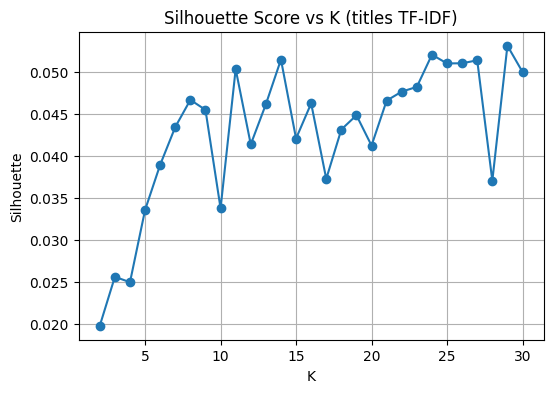

Content-based example from 0.0 -> ['29.0', '1043.0', '12.0', '1366.0', '162.0']


In [10]:
def build_articles_from_interactions(inter_df: pd.DataFrame) -> pd.DataFrame:
    """Build (article_id, title) table using most frequent title per id; synthesize if missing."""
    if inter_df["title"].isna().all():
        arts = pd.DataFrame({"article_id": inter_df["article_id"].drop_duplicates().astype(str).values})
        arts["title"] = "Article " + arts["article_id"]
        return arts
    tmp = inter_df[["article_id","title"]].dropna().astype({"article_id":"str"})
    id_to_title = tmp.groupby("article_id")["title"].agg(lambda s: Counter(s).most_common(1)[0][0]).to_dict()
    return pd.DataFrame({"article_id": list(id_to_title.keys()), "title": list(id_to_title.values())})

articles = build_articles_from_interactions(interactions).dropna(subset=["title"]).copy()
articles["article_id"] = articles["article_id"].astype(str)
print("Articles table:", articles.shape)

CONTENT_READY = len(articles) >= 10
if CONTENT_READY:
    vec = TfidfVectorizer(stop_words="english", max_features=5000)
    X_titles = vec.fit_transform(articles["title"].astype(str))

    Ks = list(range(2, min(31, max(3, X_titles.shape[0] // 2))))
    best_k, best_s, sils = None, -1.0, []
    for k in Ks:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_titles)
        if len(set(labels)) < 2:
            continue
        s = silhouette_score(X_titles, labels)
        sils.append((k,s))
        if s > best_s: best_k, best_s = k, s
    K_OPT = best_k if best_k is not None else 8
    print(f"Chosen K via silhouette: {K_OPT} (score={best_s:.3f})")

    kmeans = KMeans(n_clusters=K_OPT, random_state=42, n_init=10)
    articles["cluster"] = kmeans.fit_predict(X_titles)

    def get_similar_articles(article_id: str, top_n: int = 10) -> List[str]:
        """Return article_ids with most similar titles in the same cluster (cosine within cluster)."""
        a = str(article_id)
        if a not in set(articles["article_id"]): return []
        row = articles.loc[articles["article_id"] == a].iloc[0]
        c = row["cluster"]
        idxs = articles.index[articles["cluster"] == c].tolist()
        subX = X_titles[idxs]
        idx_in_sub = idxs.index(row.name)
        sims = cosine_similarity(subX[idx_in_sub], subX).ravel()
        order = sims.argsort()[::-1]
        ids = articles.iloc[[idxs[i] for i in order]]["article_id"].tolist()
        return [i for i in ids if i != a][:top_n]

    # Optional: silhouette plot
    if sils:
        xs, ys = zip(*sils)
        plt.figure(figsize=(6,4))
        plt.plot(xs, ys, marker="o")
        plt.title("Silhouette Score vs K (titles TF-IDF)")
        plt.xlabel("K"); plt.ylabel("Silhouette"); plt.grid(True); plt.show()

    example_id = articles["article_id"].iloc[0]
    print("Content-based example from", example_id, "->", get_similar_articles(example_id, 5))
else:
    print("Content-based skipped: not enough article titles for clustering.")


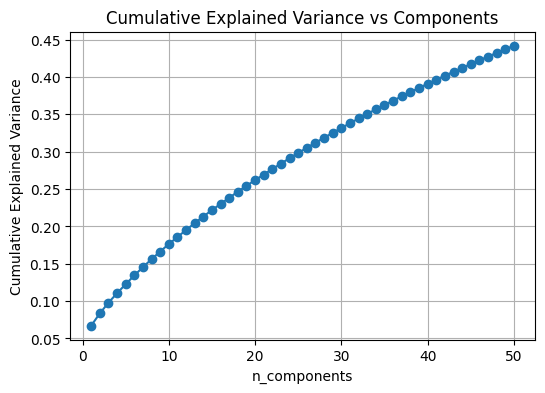

Chosen latent features: 50
U shape: (5148, 50) | Sigma shape: (50,) | Vt shape: (50, 714)
SVD item–item recs for 0.0 -> ['1112.0', '1124.0', '1292.0', '1066.0', '409.0', '766.0', '547.0', '1054.0', '349.0', '940.0']


In [11]:
def plot_evr_and_choose_k(ui_float: pd.DataFrame, max_comps: int = 50, target_evr: float = 0.90) -> int:
    """Plot cumulative explained variance to choose k. Returns chosen k."""
    if ui_float.shape[1] <= 2:
        print("Not enough items for SVD."); return 2
    comps = min(max_comps, ui_float.shape[1] - 1)
    svd = TruncatedSVD(n_components=comps, random_state=42)
    svd.fit(ui_float)
    evr_cum = np.cumsum(svd.explained_variance_ratio_)
    plt.figure(figsize=(6,4))
    plt.plot(range(1, comps + 1), evr_cum, marker="o")
    plt.title("Cumulative Explained Variance vs Components")
    plt.xlabel("n_components"); plt.ylabel("Cumulative Explained Variance"); plt.grid(True); plt.show()
    k = int(np.searchsorted(evr_cum, target_evr) + 1)
    k = max(2, min(k, comps))
    print("Chosen latent features:", k)
    return k

ui_float = (interactions.assign(val=1)
            .pivot_table(index="user_id", columns="article_id", values="val", aggfunc="max")
            .fillna(0).astype(float))

K_LATENT = plot_evr_and_choose_k(ui_float, max_comps=50, target_evr=0.90)

svd_opt = TruncatedSVD(n_components=K_LATENT, random_state=42)
U = svd_opt.fit_transform(ui_float)   # (n_users, k)
Sigma = svd_opt.singular_values_      # (k,)
Vt = svd_opt.components_              # (k, n_items)
item_factors = Vt.T                   # (n_items, k)

print("U shape:", U.shape, "| Sigma shape:", Sigma.shape, "| Vt shape:", Vt.shape)

item_ids = ui_float.columns.tolist()
id_to_col = {aid: i for i, aid in enumerate(item_ids)}
col_to_id = {i: aid for aid, i in id_to_col.items()}

def get_svd_similar_article_ids(article_id: str, top_n: int = 10) -> List[str]:
    """Return article_ids most similar to `article_id` in SVD latent space (cosine)."""
    a = str(article_id)
    if a not in id_to_col: return []
    idx = id_to_col[a]
    sims = cosine_similarity(item_factors[idx].reshape(1,-1), item_factors).ravel()
    order = sims.argsort()[::-1]
    recs = []
    for j in order:
        aid = col_to_id[j]
        if aid != a:
            recs.append(aid)
        if len(recs) >= top_n:
            break
    return recs

# Demo
if item_ids:
    demo_item = item_ids[0]
    print("SVD item–item recs for", demo_item, "->", get_svd_similar_article_ids(demo_item, 10))


**Why SVD?** Projects users/items into a shared latent space capturing co-interaction structure.  
**k selection:** Smallest k achieving ~90% EVR (printed above).


In [12]:
# === Robust Hit-Rate@10 ===

def build_clean_pairs(df: pd.DataFrame) -> pd.DataFrame:
    pairs = (df[["user_id","article_id"]]
             .drop_duplicates()
             .dropna(subset=["user_id","article_id"])
             .copy())
    pairs["user_id"] = pairs["user_id"].astype(str)
    pairs["article_id"] = pairs["article_id"].astype(str)
    return pairs

pairs = build_clean_pairs(interactions)

# Require >=2 interactions per user for stratify
user_counts = pairs["user_id"].value_counts()
eligible_users = user_counts[user_counts >= 2].index
pairs_eligible = pairs[pairs["user_id"].isin(eligible_users)].copy()

def can_stratify(df: pd.DataFrame) -> bool:
    if df["user_id"].nunique() < 2 or df["article_id"].nunique() < 3: return False
    return (df["user_id"].value_counts() >= 2).all()

use_df = pairs_eligible if len(pairs_eligible) >= 20 else pairs

try:
    if can_stratify(use_df):
        train_pairs, test_pairs = train_test_split(use_df, test_size=0.1, random_state=42, stratify=use_df["user_id"])
        split_msg = "stratified by user_id"
    else:
        train_pairs, test_pairs = train_test_split(use_df, test_size=0.1, random_state=42, shuffle=True)
        split_msg = "non-stratified"
except ValueError as e:
    print("Split failed; fallback to non-stratified:", e)
    train_pairs, test_pairs = train_test_split(use_df, test_size=min(0.1, max(1/max(len(use_df),1), 0.05)),
                                               random_state=42, shuffle=True)
    split_msg = "non-stratified (fallback)"
print("Split method:", split_msg)

train_ui = (train_pairs.assign(val=1)
            .pivot_table(index="user_id", columns="article_id", values="val", aggfunc="max")
            .fillna(0).astype(float))

if train_ui.shape[1] > 2 and train_ui.shape[0] > 1:
    comps = min(50, max(2, min(200, train_ui.shape[1]-1)))
    svd_eval = TruncatedSVD(n_components=comps, random_state=42)
    Utr = svd_eval.fit_transform(train_ui)
    Vtr = svd_eval.components_.T

    user_index = train_ui.index.tolist()
    item_index = train_ui.columns.tolist()
    uid_to_row = {u:i for i,u in enumerate(user_index)}

    def topk_svd_for_user(u, k=10):
        if u not in uid_to_row:
            return train_pairs["article_id"].value_counts().head(k).index.tolist()
        uvec = Utr[uid_to_row[u]]
        scores = Vtr @ uvec
        seen = set(train_ui.columns[train_ui.loc[u] > 0]) if u in train_ui.index else set()
        cand = [(item_index[j], scores[j]) for j in range(len(item_index)) if item_index[j] not in seen]
        cand.sort(key=lambda x: x[1], reverse=True)
        return [c[0] for c in cand[:k]]

    K = 10
    test_users = test_pairs["user_id"].unique().tolist()
    hits = sum(any(it in topk_svd_for_user(u, k=K)
                   for it in test_pairs.loc[test_pairs["user_id"] == u, "article_id"].tolist())
               for u in test_users)
    total = len(test_users)
    hit_rate = hits / total if total else 0.0
    print(f"Hit-Rate@{K}: {hit_rate:.3f}  (users evaluated: {total})")
else:
    print("Not enough users/items to run SVD evaluation.")


Split failed; fallback to non-stratified: The test_size = 3212 should be greater or equal to the number of classes = 3591
Split method: non-stratified (fallback)
Hit-Rate@10: 0.259  (users evaluated: 1054)


## Results Discussion

**Rank-based:** Strong for cold-start.  
**User–User CF:** Personalizes by overlap in reading history. `user_user_recs_part2` prioritizes power users when similarities tie and ranks candidates by popularity.  
**Content-based:** TF-IDF on titles with **silhouette-selected K** groups topical neighbors; cosine within cluster gives related reads with no user history.  
**SVD:** Learns latent themes; item-item similarity in latent space performs well, with k chosen by EVR≈0.90.

**Production testing:**
- *Offline:* Recall@K, MAP@K on time-based splits; ablate each method.  
- *Online:* A/B test CTR, dwell time, downstream reads; add diversity/novelty constraints.  
- *Cold-start:* Monitor new-user & new-item coverage (blend rank-based + content-based).
